1) Master Code 
    - API call from medicaid.gov site
    - Extrapolate data of interest from their entire database
    - import extrapolated data to Mysql database

In [ ]:
# 1) updating the database from the API - - MASTER CODE keep this <<this portion is done>>

import requests
import mysql.connector
from itertools import islice

# MySQL Configuration
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "password!",
    "database": "fundamental_database",
}

page_size = 10000
new_counter = 0

def chunks(data, batch_size):
    """Yield successive batch-sized chunks from data."""
    iterator = iter(data)
    for first in iterator:
        yield list(islice(iterator, batch_size))

while True:
    api_url = f"https://data.medicaid.gov/api/1/datastore/query/4a00010a-132b-4e4d-a611-543c9521280f/0?limit={page_size}&offset={new_counter}&count=true&results=true&schema=true&keys=true&format=json&rowids=false"

    try:
        # Send a GET request to the API
        response = requests.get(api_url)

        if response.status_code == 200:
            data = response.json()

            if 'results' in data:
                # Connect to MySQL
                connection = mysql.connector.connect(**db_config)

                if connection.is_connected():
                    db_info = connection.get_server_info()
                    print(f"Connected to MySQL Server version {db_info}")

                    cursor = connection.cursor()

                    # Check if the table exists
                    table_name = "med_price"
                    cursor.execute(f"SHOW TABLES LIKE '{table_name}'")

                    if not cursor.fetchone():
                        cursor.execute(f"CREATE TABLE {table_name} (NDC_Description VARCHAR(255), NADAC_Per_Unit DECIMAL(10, 5), Effective_Date DATE)")
                        print(f"Table '{table_name}' created.")

                    # Prepare data for batch insertion
                    all_records = [(result.get('ndc_description', 'N/A'), 
                                    result.get('nadac_per_unit', '0.0'), 
                                    result.get('effective_date', 'N/A')) for result in data['results']]

                    # Insert data in batches of 200
                    insert_query = "INSERT INTO med_price (NDC_Description, NADAC_Per_Unit, Effective_Date) VALUES (%s, %s, %s)"
                    for batch in chunks(all_records, 200):
                        cursor.executemany(insert_query, batch)

                    connection.commit()
                    cursor.close()
                    connection.close()
                    print("MySQL connection is closed")

                # If the length of results is less than page_size, it's the last page
                if len(data['results']) < page_size:
                    break

            else:
                print("No 'results' key in the JSON response")
                break

        else:
            print(f"Failed to fetch data from API. Status code: {response.status_code}")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the API request: {e}")
    except mysql.connector.Error as err:
        print(f"Error occurred with MySQL: {err}")

    new_counter += page_size


2) basic statistic of medication price
    - Mean, median , mode, Standard Deviation, Variance,Range,Interquartile Range (IQR) 

In [ ]:
# pip install sqlalchemy

In [5]:
# Mean, median , mode, Standard Deviation, Variance,Range,Interquartile Range (IQR)
import pandas as pd
from sqlalchemy import create_engine

# MySQL Configuration
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "password!",
    "database": "fundamental_database",
}

# SQLAlchemy connection string
connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Fetch data into a pandas DataFrame
try:
    query = "SELECT NADAC_Per_Unit FROM med_price"
    df = pd.read_sql(query, engine)
except Exception as err:
    print(f"Error occurred: {err}")

# Close the engine
engine.dispose()

# Calculate statistics
mean_price = df['NADAC_Per_Unit'].mean()
median_price = df['NADAC_Per_Unit'].median()
mode_price = df['NADAC_Per_Unit'].mode()[0]
std_dev_price = df['NADAC_Per_Unit'].std()
variance_price = df['NADAC_Per_Unit'].var()
range_price = df['NADAC_Per_Unit'].max() - df['NADAC_Per_Unit'].min()
iqr_price = df['NADAC_Per_Unit'].quantile(0.75) - df['NADAC_Per_Unit'].quantile(0.25)

# Output results
print(f"Mean Price: {mean_price}")
print(f"Median Price: {median_price}")
print(f"Mode Price: {mode_price}")
print(f"Standard Deviation: {std_dev_price}")
print(f"Variance: {variance_price}")
print(f"Range: {range_price}")
print(f"Interquartile Range: {iqr_price}")


Mean Price: 12.942564594347742
Median Price: 0.19155
Mode Price: 0.6088
Standard Deviation: 301.9654685568077
Variance: 91183.14420073244
Range: 25583.016499999998
Interquartile Range: 0.59714


3) graphical representation (with outlier):  
    - Mean, Median, Mode. Standard Deviation

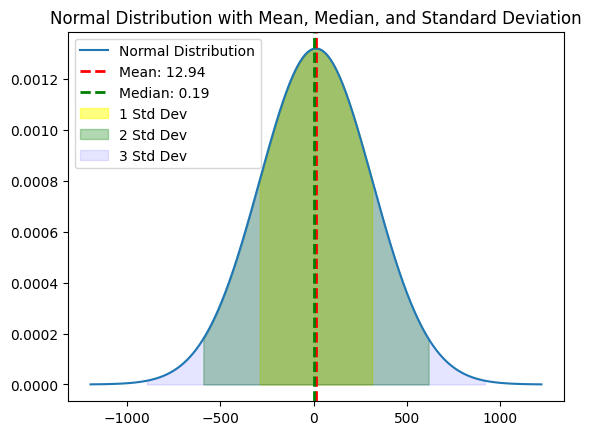

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sqlalchemy import create_engine

# MySQL Configuration
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "password!",
    "database": "fundamental_database",
}

# SQLAlchemy connection string
connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Fetch data into a pandas DataFrame
try:
    query = "SELECT NADAC_Per_Unit FROM med_price"
    df = pd.read_sql(query, engine)
except Exception as err:
    print(f"Error occurred: {err}")
finally:
    engine.dispose()

# Calculate mean, median, and standard deviation
mean = df['NADAC_Per_Unit'].mean()
median = df['NADAC_Per_Unit'].median()
std_dev = df['NADAC_Per_Unit'].std()

# Create points for the normal distribution curve
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
y = norm.pdf(x, mean, std_dev)

# Plot the normal distribution curve
plt.plot(x, y, label='Normal Distribution')

# Plot mean, median
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

# Shade standard deviation intervals
plt.fill_between(x, y, where=(x > mean - std_dev) & (x < mean + std_dev), color='yellow', alpha=0.5, label='1 Std Dev')
plt.fill_between(x, y, where=(x > mean - 2*std_dev) & (x < mean + 2*std_dev), color='green', alpha=0.3, label='2 Std Dev')
plt.fill_between(x, y, where=(x > mean - 3*std_dev) & (x < mean + 3*std_dev), color='blue', alpha=0.1, label='3 Std Dev')

# Add labels, title, and legend
plt.title('Normal Distribution with Mean, Median, and Standard Deviation')
plt.legend(loc='upper left')
plt.show()


4) graphical representation (with Outlier):


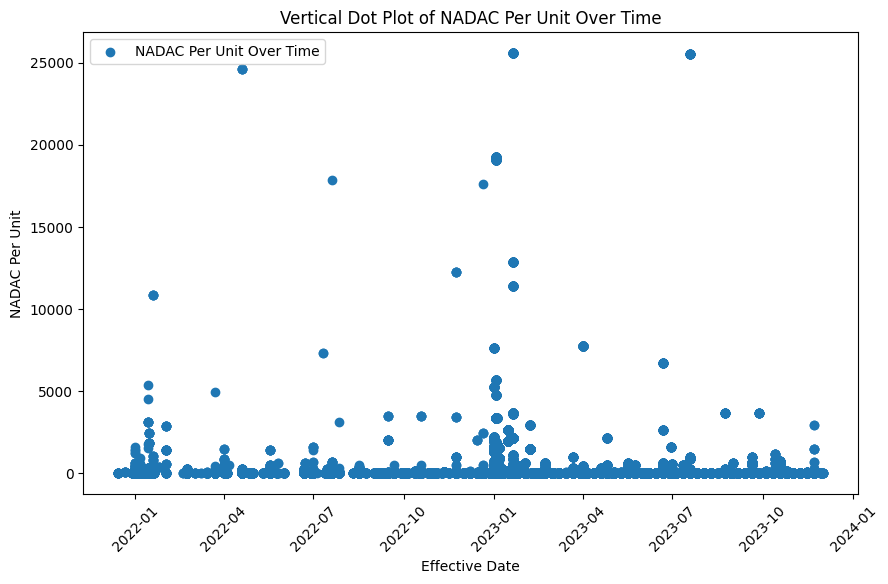

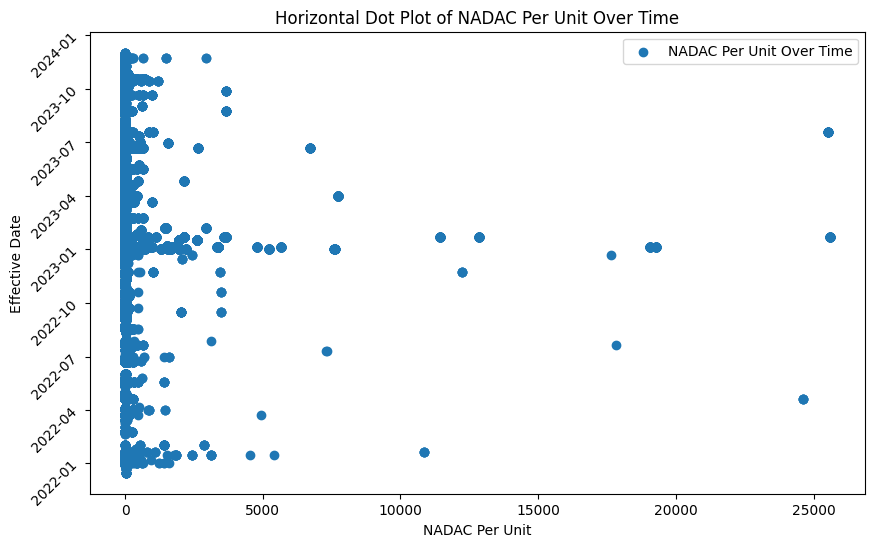

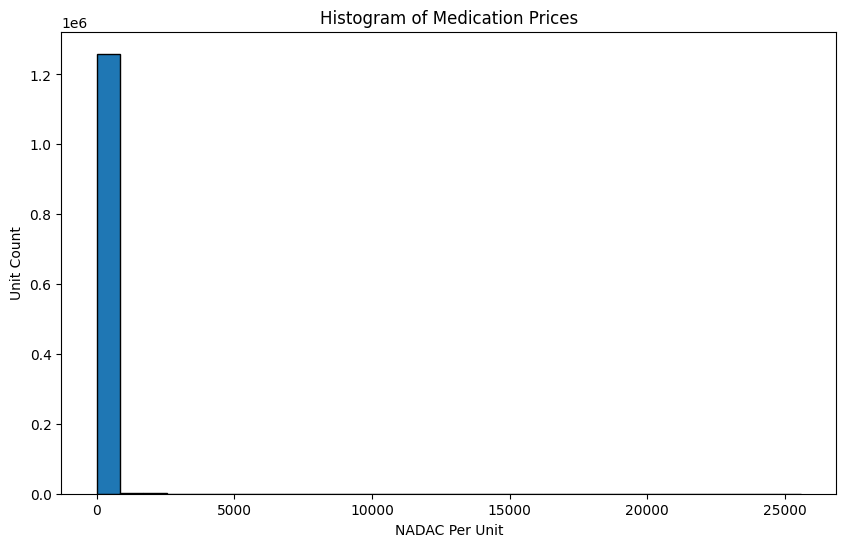

C:\Users\hyper\AppData\Local\Temp\ipykernel_76792\2466350630.py:70: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['NADAC_Per_Unit'].dropna(), shade=True)


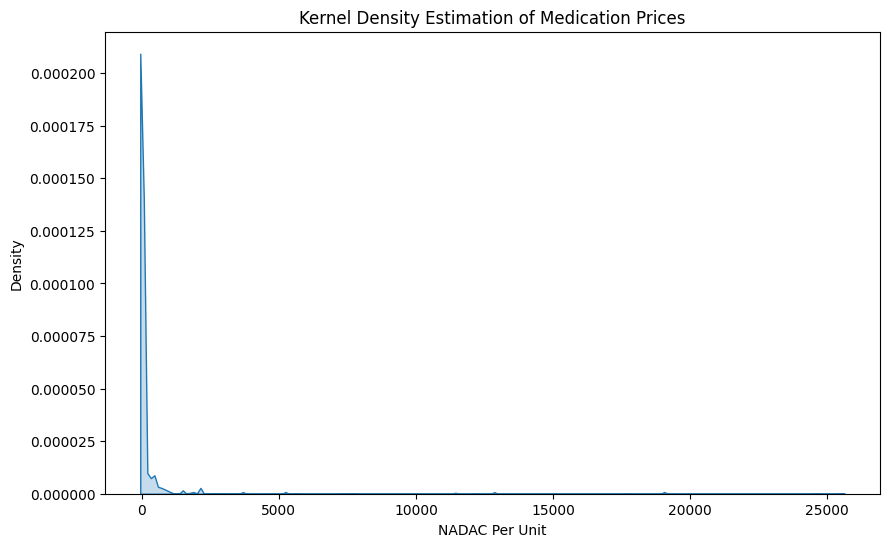

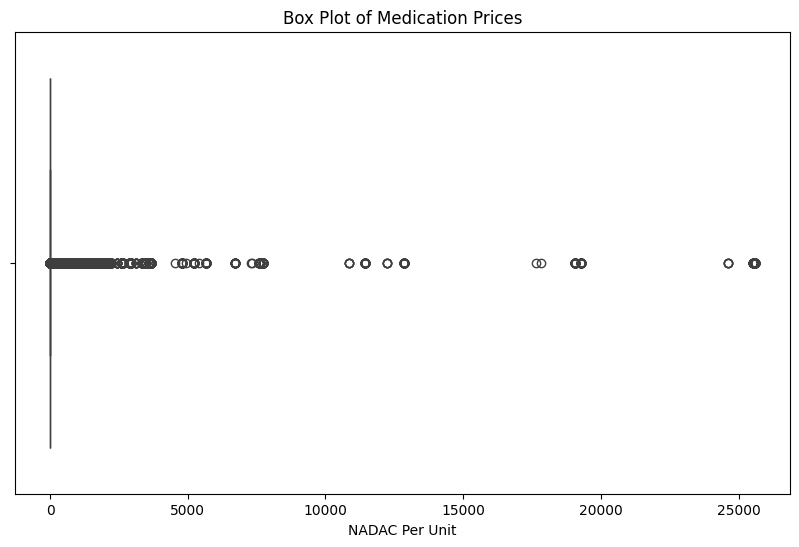

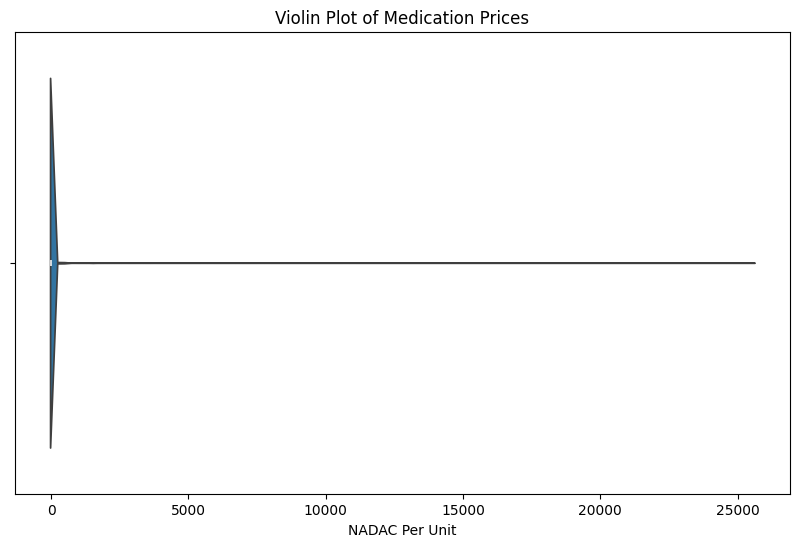

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

# MySQL Configuration
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "password!",
    "database": "fundamental_database",
}

# SQLAlchemy connection string
connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Fetch data into a pandas DataFrame
try:
    query = "SELECT NADAC_Per_Unit, Effective_Date FROM med_price"
    df = pd.read_sql(query, engine)
    df['Effective_Date'] = pd.to_datetime(df['Effective_Date'])  # Convert to datetime
    df.sort_values('Effective_Date', inplace=True)  # Sort by date
except Exception as err:
    print(f"Error occurred: {err}")
finally:
    engine.dispose()

# Plotting the Vertical Dot Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Effective_Date'], df['NADAC_Per_Unit'], label='NADAC Per Unit Over Time')
plt.xlabel('Effective Date')
plt.ylabel('NADAC Per Unit')
plt.title('Vertical Dot Plot of NADAC Per Unit Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plotting the Horizontal Dot Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['NADAC_Per_Unit'], df['Effective_Date'], label='NADAC Per Unit Over Time')
plt.ylabel('Effective Date')
plt.xlabel('NADAC Per Unit')
plt.title('Horizontal Dot Plot of NADAC Per Unit Over Time')
plt.yticks(rotation=45)
plt.legend()
plt.show()


# Fetch data into a pandas DataFrame
try:
    query = "SELECT NADAC_Per_Unit FROM med_price"
    df = pd.read_sql(query, engine)
except Exception as err:
    print(f"Error occurred: {err}")
finally:
    engine.dispose()

# Plot 1: Histogram of Medication Prices
plt.figure(figsize=(10, 6))
plt.hist(df['NADAC_Per_Unit'].dropna(), bins=30, edgecolor='black')
plt.xlabel('NADAC Per Unit')
plt.ylabel('Unit Count')
plt.title('Histogram of Medication Prices')
plt.show()

# Plot 2: Kernel Density Estimation of Medication Prices
plt.figure(figsize=(10, 6))
sns.kdeplot(df['NADAC_Per_Unit'].dropna(), shade=True)
plt.xlabel('NADAC Per Unit')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Medication Prices')
plt.show()

# Plot 3: Box Plot of Medication Prices
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['NADAC_Per_Unit'].dropna())
plt.xlabel('NADAC Per Unit')
plt.title('Box Plot of Medication Prices')
plt.show()

# Plot 4: Violin Plot of Medication Prices
plt.figure(figsize=(10, 6))
sns.violinplot(x=df['NADAC_Per_Unit'].dropna())
plt.xlabel('NADAC Per Unit')
plt.title('Violin Plot of Medication Prices')
plt.show()


5) updated statistic without the outlier

In [98]:
import pandas as pd
from sqlalchemy import create_engine

# MySQL Configuration
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "password!",
    "database": "fundamental_database",
}

# SQLAlchemy connection string
connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Fetch data into a pandas DataFrame
try:
    query = "SELECT NADAC_Per_Unit FROM med_price"
    df = pd.read_sql(query, engine)
    df = remove_outliers(df, 'NADAC_Per_Unit')  # Remove outliers
except Exception as err:
    print(f"Error occurred: {err}")
finally:
    engine.dispose()

# Calculate statistics without outliers
mean_price = df['NADAC_Per_Unit'].mean()
median_price = df['NADAC_Per_Unit'].median()
mode_price = df['NADAC_Per_Unit'].mode()[0] if not df['NADAC_Per_Unit'].mode().empty else 'No mode'
std_dev_price = df['NADAC_Per_Unit'].std()
variance_price = df['NADAC_Per_Unit'].var()
range_price = df['NADAC_Per_Unit'].max() - df['NADAC_Per_Unit'].min()
iqr_price = df['NADAC_Per_Unit'].quantile(0.75) - df['NADAC_Per_Unit'].quantile(0.25)

# Output results
print(f"Mean Price: {mean_price}")
print(f"Median Price: {median_price}")
print(f"Mode Price: {mode_price}")
print(f"Standard Deviation: {std_dev_price}")
print(f"Variance: {variance_price}")
print(f"Range: {range_price}")
print(f"Interquartile Range: {iqr_price}")


Mean Price: 0.26919370512064805
Median Price: 0.14325
Mode Price: 0.6088
Standard Deviation: 0.3127534755605625
Variance: 0.09781473647521137
Range: 1.57057
Interquartile Range: 0.2659


6) updated normal distributional graph without outlier

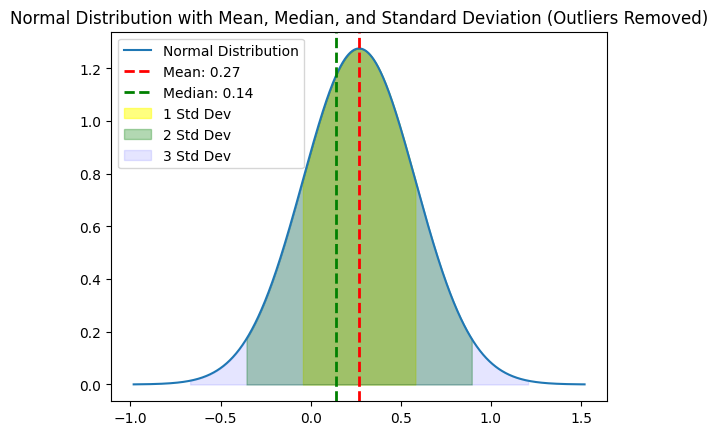

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sqlalchemy import create_engine

# MySQL Configuration
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "password!",
    "database": "fundamental_database",
}

# SQLAlchemy connection string
connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Fetch data into a pandas DataFrame and remove outliers
try:
    query = "SELECT NADAC_Per_Unit FROM med_price"
    df = pd.read_sql(query, engine)
    df = remove_outliers(df, 'NADAC_Per_Unit')  # Remove outliers
except Exception as err:
    print(f"Error occurred: {err}")
finally:
    engine.dispose()

# Calculate mean, median, and standard deviation
mean = df['NADAC_Per_Unit'].mean()
median = df['NADAC_Per_Unit'].median()
std_dev = df['NADAC_Per_Unit'].std()

# Create points for the normal distribution curve
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
y = norm.pdf(x, mean, std_dev)

# Plot the normal distribution curve
plt.plot(x, y, label='Normal Distribution')

# Plot mean, median
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

# Shade standard deviation intervals
plt.fill_between(x, y, where=(x > mean - std_dev) & (x < mean + std_dev), color='yellow', alpha=0.5, label='1 Std Dev')
plt.fill_between(x, y, where=(x > mean - 2*std_dev) & (x < mean + 2*std_dev), color='green', alpha=0.3, label='2 Std Dev')
plt.fill_between(x, y, where=(x > mean - 3*std_dev) & (x < mean + 3*std_dev), color='blue', alpha=0.1, label='3 Std Dev')

# Add labels, title, and legend
plt.title('Normal Distribution with Mean, Median, and Standard Deviation (Outliers Removed)')
plt.legend(loc='upper left')
plt.show()


7) graphical representation  without outliers

C:\Users\hyper\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


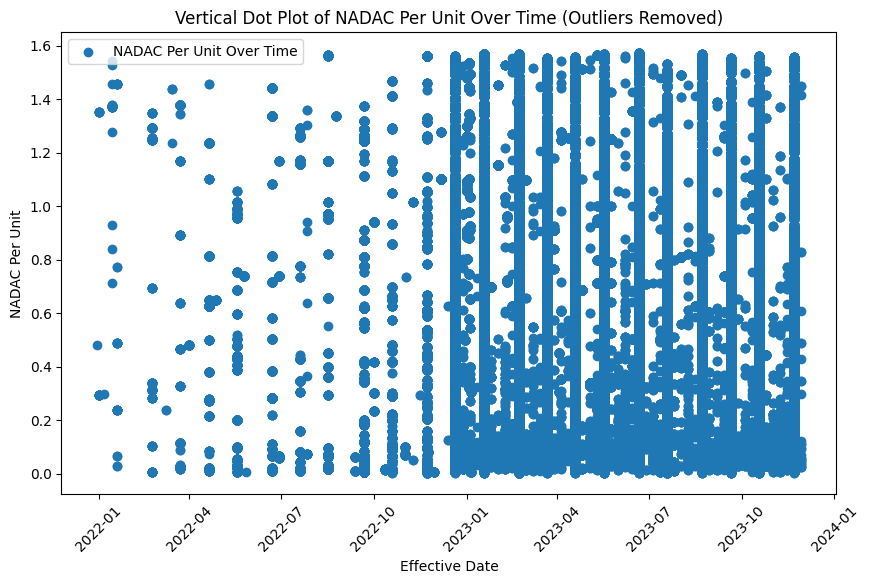

C:\Users\hyper\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


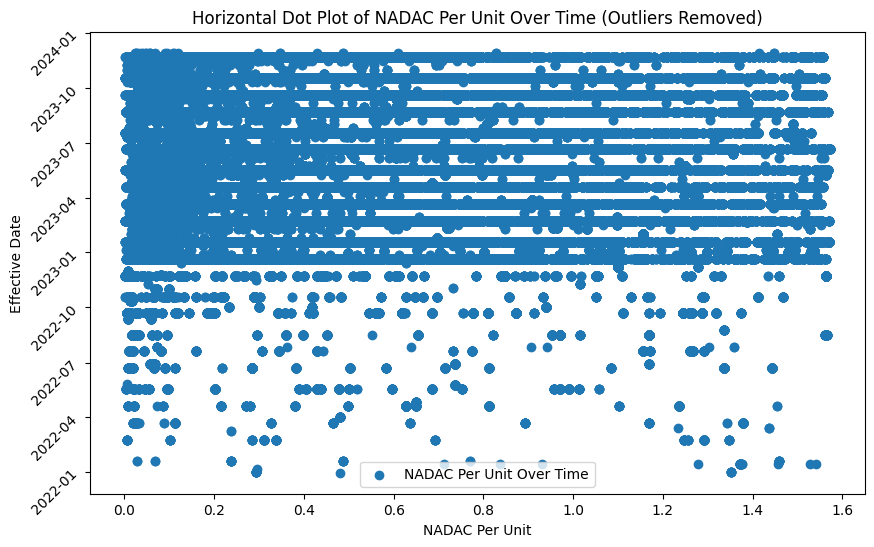

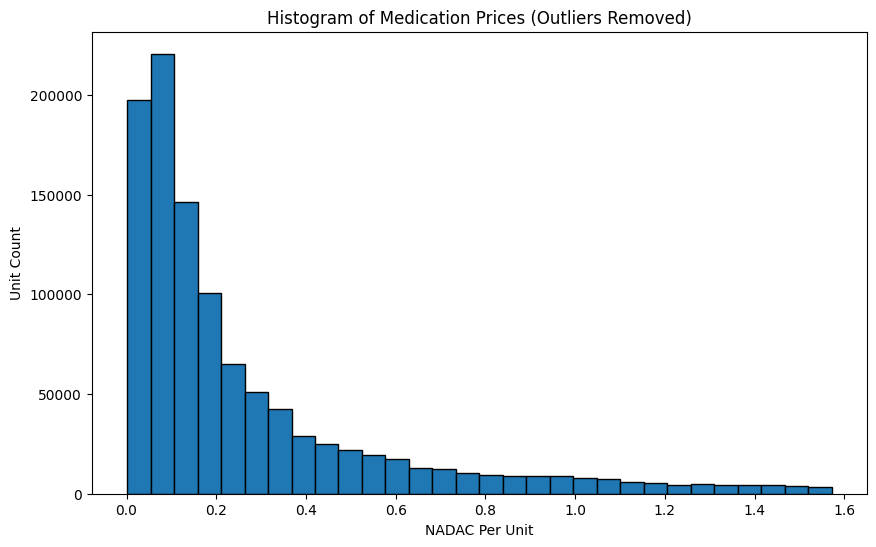

C:\Users\hyper\AppData\Local\Temp\ipykernel_76792\2702622690.py:74: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean['NADAC_Per_Unit'].dropna(), shade=True)


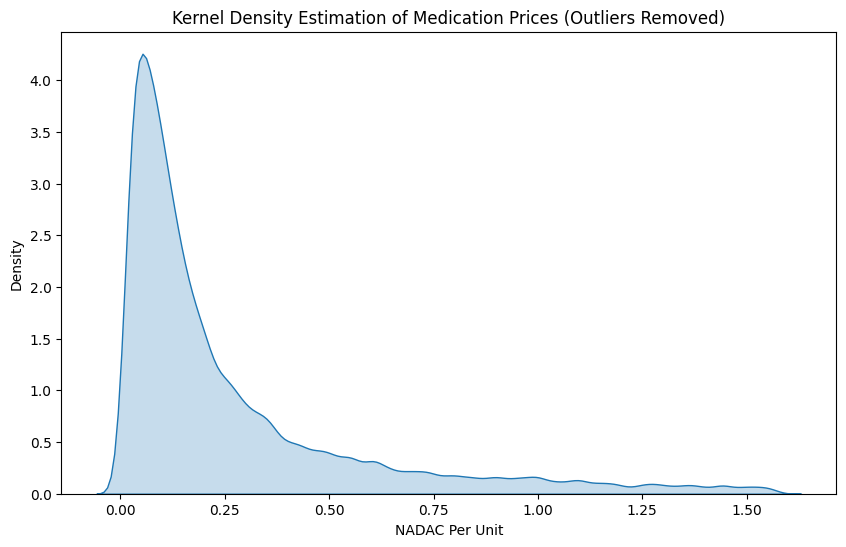

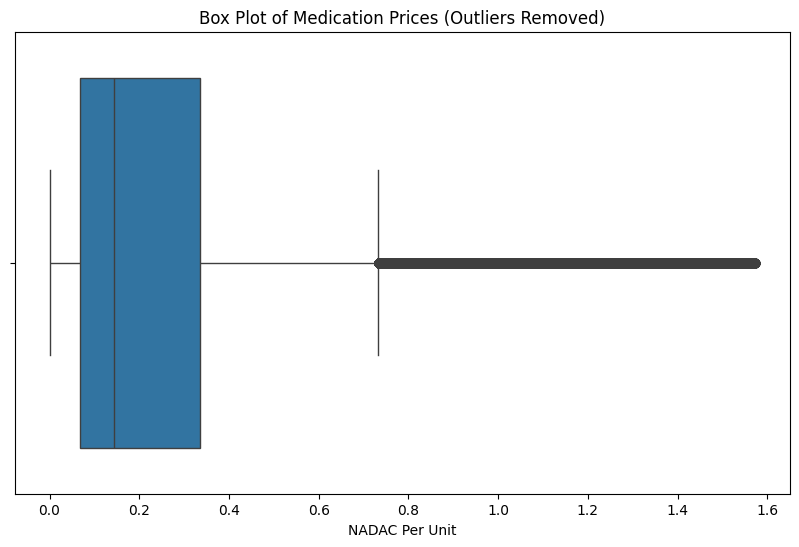

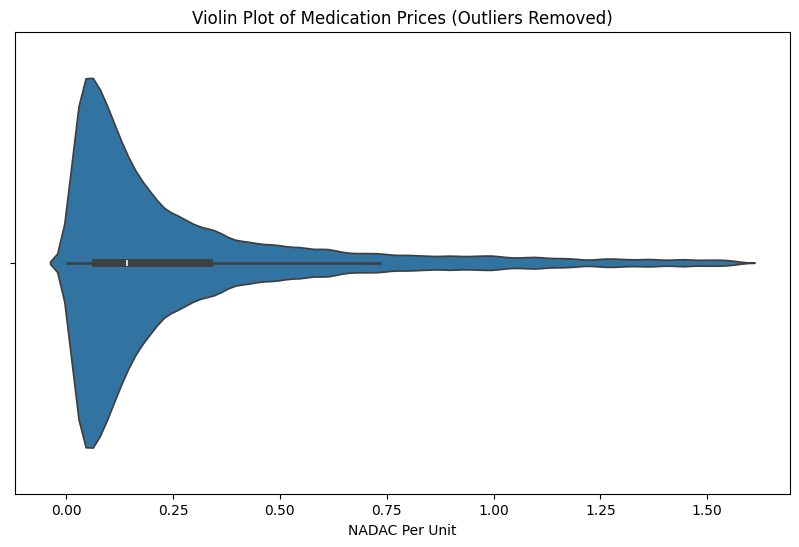

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

# MySQL Configuration
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "password!",
    "database": "fundamental_database",
}

# SQLAlchemy connection string
connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Fetch and process data
try:
    # Fetching data
    query = "SELECT NADAC_Per_Unit, Effective_Date FROM med_price"
    df = pd.read_sql(query, engine)
    df['Effective_Date'] = pd.to_datetime(df['Effective_Date'])  # Convert to datetime
    df.sort_values('Effective_Date', inplace=True)  # Sort by date
    df_clean = remove_outliers(df, 'NADAC_Per_Unit')  # Remove outliers
except Exception as err:
    print(f"Error occurred: {err}")
finally:
    engine.dispose()

# Plotting with outliers removed

# Vertical Dot Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Effective_Date'], df_clean['NADAC_Per_Unit'], label='NADAC Per Unit Over Time')
plt.xlabel('Effective Date')
plt.ylabel('NADAC Per Unit')
plt.title('Vertical Dot Plot of NADAC Per Unit Over Time (Outliers Removed)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Horizontal Dot Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['NADAC_Per_Unit'], df_clean['Effective_Date'], label='NADAC Per Unit Over Time')
plt.ylabel('Effective Date')
plt.xlabel('NADAC Per Unit')
plt.title('Horizontal Dot Plot of NADAC Per Unit Over Time (Outliers Removed)')
plt.yticks(rotation=45)
plt.legend()
plt.show()

# Histogram of Medication Prices
plt.figure(figsize=(10, 6))
plt.hist(df_clean['NADAC_Per_Unit'].dropna(), bins=30, edgecolor='black')
plt.xlabel('NADAC Per Unit')
plt.ylabel('Unit Count')
plt.title('Histogram of Medication Prices (Outliers Removed)')
plt.show()

# Kernel Density Estimation of Medication Prices
plt.figure(figsize=(10, 6))
sns.kdeplot(df_clean['NADAC_Per_Unit'].dropna(), shade=True)
plt.xlabel('NADAC Per Unit')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Medication Prices (Outliers Removed)')
plt.show()

# Box Plot of Medication Prices
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['NADAC_Per_Unit'].dropna())
plt.xlabel('NADAC Per Unit')
plt.title('Box Plot of Medication Prices (Outliers Removed)')
plt.show()

# Violin Plot of Medication Prices
plt.figure(figsize=(10, 6))
sns.violinplot(x=df_clean['NADAC_Per_Unit'].dropna())
plt.xlabel('NADAC Per Unit')
plt.title('Violin Plot of Medication Prices (Outliers Removed)')
plt.show()


8) If you want to keep the outlier, use Log technique for graphical representation

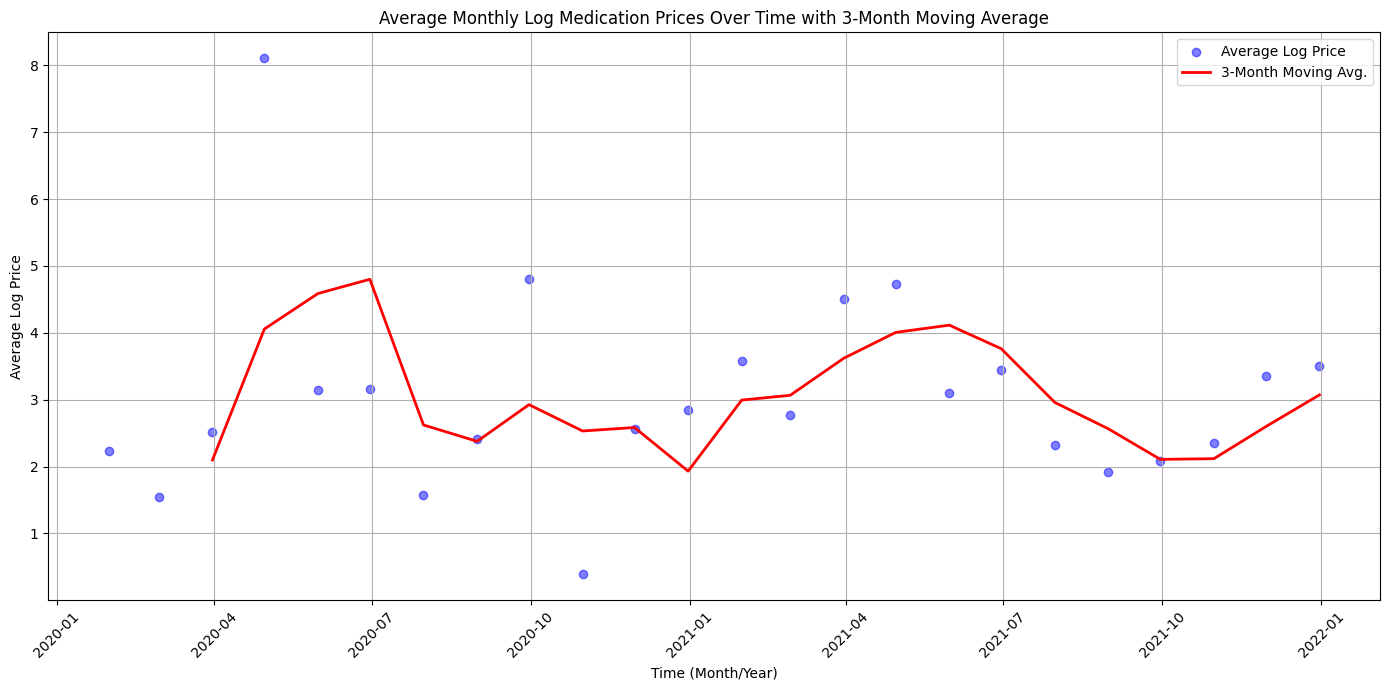

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame creation
# Assuming 'monthly_avg_log_prices' is a DataFrame with an index of dates and a column for log prices
dates = pd.date_range(start='2020-01-01', periods=24, freq='M')  # Monthly dates for 2 years
log_prices = np.random.lognormal(mean=1, sigma=0.5, size=24)     # Random log-normal distribution prices
monthly_avg_log_prices = pd.DataFrame(log_prices, index=dates, columns=['Average Log Price'])

# Define a window size for the moving average
window_size = 3  # For example, a 3-month moving average

# Calculate the moving average of the monthly average log prices
moving_avg = monthly_avg_log_prices.rolling(window=window_size).mean()

plt.figure(figsize=(14, 7))

# Original data
plt.scatter(monthly_avg_log_prices.index, monthly_avg_log_prices['Average Log Price'], color='blue', alpha=0.5, label='Average Log Price')

# Moving average data
plt.plot(moving_avg.index, moving_avg['Average Log Price'], color='red', linewidth=2, label=f'{window_size}-Month Moving Avg.')

# Formatting the graph
plt.title(f"Average Monthly Log Medication Prices Over Time with {window_size}-Month Moving Average")
plt.xlabel("Time (Month/Year)")
plt.ylabel("Average Log Price")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.show()


9) answer to our hypothesis

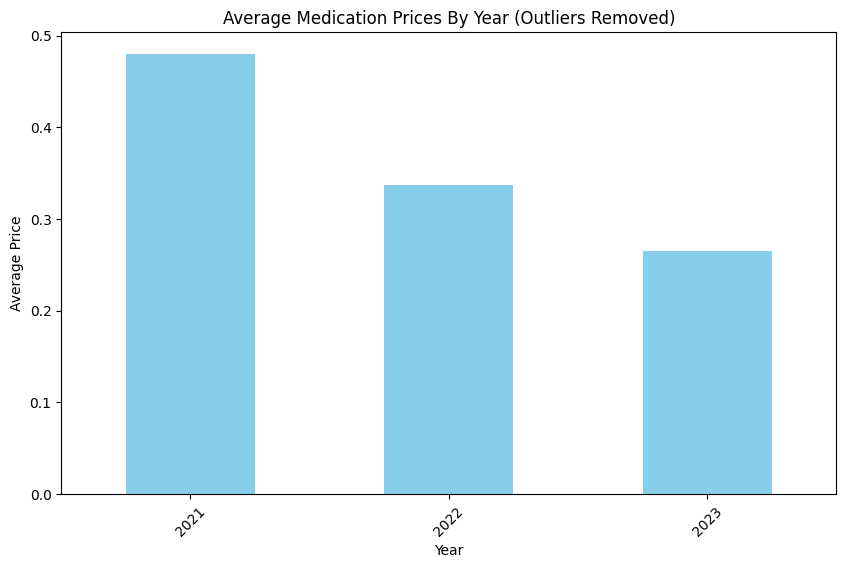

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# MySQL Configuration
db_config = {
    "host": "127.0.0.1",
    "user": "root",
    "password": "password!",
    "database": "fundamental_database",
}

# SQLAlchemy connection string
connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Fetch data into a pandas DataFrame
try:
    query = "SELECT NADAC_Per_Unit, Effective_Date FROM med_price"
    df = pd.read_sql(query, engine)
    df['Effective_Date'] = pd.to_datetime(df['Effective_Date'])  # Convert to datetime
    df = remove_outliers(df, 'NADAC_Per_Unit')  # Remove outliers
except Exception as err:
    print(f"Error occurred: {err}")
finally:
    engine.dispose()

# Extract year from Effective_Date
df['Year'] = df['Effective_Date'].dt.year

# Group by year and calculate average price
average_prices_by_year = df.groupby('Year')['NADAC_Per_Unit'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_prices_by_year.plot(kind='bar', color='skyblue')
plt.title('Average Medication Prices By Year (Outliers Removed)')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()
